In [158]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

from keras.models import Sequential
from ZooMeR import ZooMeR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import astropy
import json
from sklearn.decomposition import PCA
from collections import Counter

% matplotlib inline

# Random Forest

In [2]:
# read in classifications ready for ML
features_imp, df = ZooMeR("ML_param.csv","lsst_run_one.csv")

#Read in the features in the data frame, filter for columns relevant for ML
features = df.columns.tolist()

features = [c for c in features if c not in ["image", "Classification"]]
target = "Classification"  #Predict on Classifications

#Cut 'useless' features and problematic features
for feature in features:
    if df[feature].isnull().all():
        del df[feature]   
    elif np.mean(df[feature]) == np.inf:
        del df[feature]
    elif "flag" in feature: #Flags don't contribute to ML based on initial testing
        del df[feature]
        
features = df.columns.tolist()

features = [c for c in features if c not in ["image", "Classification"]]

In [3]:
#Random Forest
target = "Classification"

RFC =  RandomForestClassifier()
RFC = RFC.fit(features_imp,df[target])

In [4]:
feature_importance = zip(RFC.feature_importances_, features)
# sorted(feature_importance, reverse=True)

In [5]:
#Split into Training Set and Testing Set

train = df.sample(frac=0.8, random_state=1)
test = df.loc[~df.index.isin(train.index)]

imp_tt = Imputer(missing_values='NaN', strategy='median', axis=0, verbose = 1)
imp_tt.fit(train[features])
features_imp_tt = imp_tt.transform(train[features])

#Random Forest Training/Test Split
RFC_tt =  RandomForestClassifier()
RFC_tt = RFC.fit(features_imp_tt,train[target])

In [6]:
imp_test = Imputer(missing_values='NaN', strategy='median', axis=0, verbose = 1)
imp_test.fit(test[features])
features_imp_test = imp_test.transform(test[features])


predictions = RFC_tt.predict(features_imp_test)

In [7]:
for index in range(len(predictions)):
    print predictions[index],",",test["Classification"].tolist()[index]

In [8]:
pred_mapping = {}
for index in range(len(predictions)):
    pred_name = predictions[index]
    class_name = test["Classification"].tolist()[index]
    if pred_name in pred_mapping:
        pred_mapping[pred_name].append(class_name)
    else:
        pred_mapping[pred_name] = [class_name]
        
for pred_name, pred_value in pred_mapping.iteritems():
    print pred_name, Counter(pred_value)

In [44]:
agree=0
agrees = []
disagree=0
for index in range(len(predictions)):
    if predictions[index] == test["Classification"].tolist()[index]:
        agree+=1
        agrees.append(index)
    else:
        disagree+=1
print "Agree: "+ str(agree), "Disagree: "+str(disagree)

In [10]:
agree, disagree

(250, 72)

In [11]:
percent=float(agree)/len(predictions)
percent

0.7763975155279503

In [12]:
ind = 57
predictions[ind],test["Classification"].tolist()[ind]

(u'Possible Transient', u'Possible Transient')

In [33]:
strval = 'u\'Dipole\''
indices = [i for i,c in enumerate(np.array(test["Classification"])) if c==strval]

In [145]:
ptindices = np.where(test["Classification"]=='Possible Transient')
ptagree = [pt for pt in ptindices[0] if predictions[pt] == test["Classification"].tolist()[pt]]

dpindices = np.where(test["Classification"]=='Dipole')
dpagree = [dp for dp in dpindices[0] if predictions[dp] == test["Classification"].tolist()[dp]]

seindices = np.where(test["Classification"]=='Subtraction Error')
seagree = [se for se in seindices[0] if predictions[se] == test["Classification"].tolist()[se]]

pvindices = np.where(test["Classification"]=='Possible Variable Star')
pvagree = [pv for pv in pvindices[0] if predictions[pv] == test["Classification"].tolist()[pv]]

noindices = np.where(test["Classification"]=='Noise')
noagree = [no for no in noindices[0] if predictions[no] == test["Classification"].tolist()[no]]

paindices = np.where(test["Classification"]=='Pixel Artifact')
paagree = [pa for pa in paindices[0] if predictions[pa] == test["Classification"].tolist()[pa]]

otindices = np.where(test["Classification"]=='Other')
otagree = [ot for ot in otindices[0] if predictions[ot] == test["Classification"].tolist()[ot]]

In [146]:
agrees = [len(ptagree),len(dpagree),len(seagree),len(pvagree),len(noagree),len(paagree),len(otagree)]
disagrees = [len(ptindices[0])-agrees[0],len(dpindices[0])-agrees[1],len(seindices[0])-agrees[2],len(pvindices[0])-agrees[3],len(noindices[0])-agrees[4],len(paindices[0])-agrees[5],len(otindices[0])-agrees[6]]

In [149]:
agrees,disagrees

([71, 58, 54, 59, 1, 7, 0], [0, 25, 27, 13, 1, 4, 0])

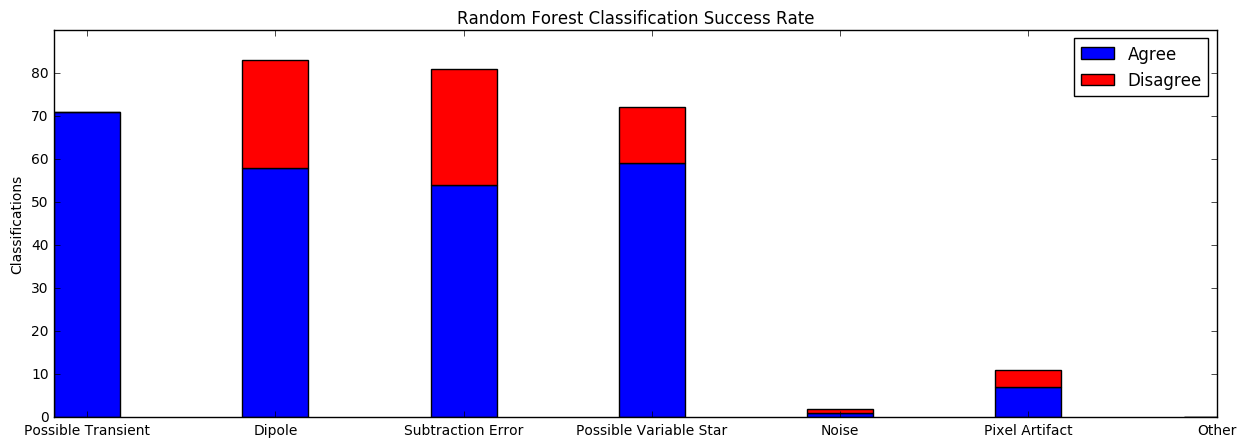

In [176]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ind = np.arange(len(agrees))
width = 0.35

p1 = ax.bar(np.arange(len(agrees)), agrees, width, color='b',label='Agree')
p2 = ax.bar(np.arange(len(agrees)), disagrees, width, color='r',label='Disagree',bottom=agrees)

ax.set_ylabel('Classifications');
ax.set_title('Random Forest Classification Success Rate');
ax.set_xlim(0,6)
ax.set_xticks(ind + width/2.)
ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('Possible Transient','Dipole','Subtraction Error','Possible Variable Star','Noise','Pixel Artifact','Other'))

pl.legend(loc=0)

pl.show()

In [175]:
len(dpindices[0])

83